In [1]:
import h5py
import numpy as np
import puma
import matplotlib.pyplot as plt
from puma import Histogram, HistogramPlot, Roc, RocPlot
from puma.metrics import calc_rej
from puma.utils import get_good_colours, get_good_linestyles, logger
from sklearn import metrics
from numpy.lib.recfunctions import structured_to_unstructured as s2u

In [2]:

def disc_fct(arr: np.ndarray) -> np.ndarray:
    """Tagger discriminant

    Parameters
    ----------
    arr : numpy.ndarray
        array with with shape (, 2)

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    # you can adapt this for your needs
    return np.log((arr[0] + 1e-10) / (arr[1] + 1e-10))


In [3]:
test_path = '/storage/agrp/dreyet/GNtau/samples/v04/output/pp_output_test.h5'
#test_path = '/storage/agrp/zivka/umami_Tau/UPP/umami-preprocessing/upp/output/pp_output_test.h5'
#'/storage/agrp/dmitrykl/tauTag/upp/output/pp_output_test.h5'

In [4]:
test_f1 = h5py.File(test_path, 'r')
    

In [5]:
jet_flav = test_f1['jets']['HadronConeExclTruthLabelID']
is_tau = jet_flav == 5

In [6]:
x = test_f1['tracks']['tauTruthProng']
x = x[is_tau]

In [7]:
sig_1_prong = np.isin(x, 1)
sig_mask_1 = np.any(sig_1_prong, axis=1)
sig_3_prong = np.isin(x, 3)
sig_mask_3 = np.any(sig_3_prong, axis=1)

In [8]:
filtered = [test_f1['tracks']['rnn_fakeScore'],test_f1['tracks']['rnn_chargedScore'],test_f1['tracks']['rnn_conversionScore'],test_f1['tracks']['rnn_isolationScore'],test_f1['tracks']['valid'],test_f1['tracks']['NewTruthType']]

In [9]:
filtered = np.stack(filtered, axis=-1)

In [10]:
filtered_tau = filtered[is_tau]
track_scores = [filtered_tau[:,:,0], filtered_tau[:,:,1], filtered_tau[:,:,2], filtered_tau[:,:,3]]
track_valids = filtered_tau[:,:,4]
track_truth = filtered_tau[:,:,5]

In [11]:
# track_scores = [test_f1['tracks']['rnn_fakeScore'], test_f1['tracks']['rnn_chargedScore'], test_f1['tracks']['rnn_isolationScore'], test_f1['tracks']['rnn_conversionScore']]
# track_valids = test_f1['tracks']['valid']
# track_truth = test_f1['tracks']['NewTruthType']

In [12]:
track_valids = np.where(track_valids == 1, True, False)

In [13]:
valid_truth = track_truth[track_valids]
valid_truth[valid_truth == 6] = 0
valid_truth[valid_truth == 5] = 0
valid_truth[valid_truth == 4] = 0
valid_truth.shape


(36541661,)

In [14]:
rnn_scores = np.stack([track_scores[0], track_scores[1], track_scores[2], track_scores[3]], axis=-1)

In [15]:
f = np.argmax(rnn_scores[track_valids], axis=-1)

In [16]:
def relabel(labels):
    labels = labels + 100 # 0 -> 100, 1 -> 101, 2 -> 102, 3 -> 103
    labels = np.where(labels == 100, 3, labels)
    labels = np.where(labels == 101, 0, labels)
    labels = np.where(labels == 102, 1, labels)
    labels = np.where(labels == 103, 2, labels)
    return labels

In [17]:
f = relabel(f)

In [18]:
valid_truth = relabel(valid_truth)

Text(0.5, 1.0, 'inclusive (only tau)')

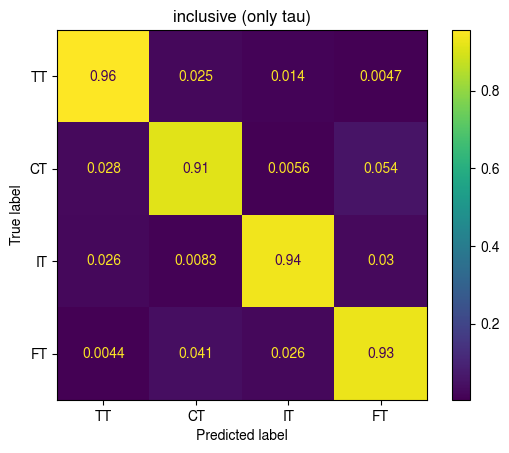

In [19]:
confusion_matrix = metrics.confusion_matrix(valid_truth, f, normalize='true')
#switched_conf_matrix = switch_axes(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels=['TT', 'CT', 'IT', 'FT'])

cm_display.plot()
plt.title('inclusive (only tau)')

In [20]:
three_prong_jet_mask = [ np.sum(track_true_labels == 1) == 3  for track_true_labels in track_truth] 

In [21]:
np.sum(l == True for l in three_prong_jet_mask)

/tmp/ipykernel_108685/3278942670.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(l == True for l in three_prong_jet_mask)


549568

In [22]:
three_prong_jet_mask = np.array(three_prong_jet_mask)

In [23]:
# filtered_data = [test_f1['tracks']['rnn_fakeScore'],test_f1['tracks']['rnn_chargedScore'],test_f1['tracks']['rnn_conversionScore'],test_f1['tracks']['rnn_isolationScore'],test_f1['tracks']['valid'],test_f1['tracks']['NewTruthType']]

In [24]:
# filtered_data = np.stack(filtered_data, axis=-1)

In [25]:
three_prong_jet_mask.shape

(3000000,)

In [26]:
(three_prong_jet_mask & sig_mask_3).shape

(3000000,)

In [27]:
filtered_3_prongs = filtered_tau[three_prong_jet_mask & sig_mask_3]

In [28]:
filtered_3_prongs.shape

(535308, 30, 6)

In [29]:
track_scores3 = [filtered_3_prongs[:,:,0], filtered_3_prongs[:,:,1], filtered_3_prongs[:,:,2], filtered_3_prongs[:,:,3]]
track_valid3 = filtered_3_prongs[:,:,4]
track_truth3 = filtered_3_prongs[:,:,5]

In [30]:
#filtered_3_prongs = test_f1['tracks'][three_prong_jet_mask,:]

In [31]:
track_valid3 = np.where(track_valid3 == 1, True, False)

In [32]:
valid_truth3 = track_truth3[track_valid3]
valid_truth3[valid_truth3 == 6] = 0
valid_truth3[valid_truth3 == 5] = 0
valid_truth3[valid_truth3 == 4] = 0
valid_truth3.shape

(6626117,)

In [33]:
rnn_scores3 = np.stack([track_scores3[0], track_scores3[1], track_scores3[2], track_scores3[3]], axis=-1)

In [34]:
f3 = np.argmax(rnn_scores3[track_valid3], axis = -1)

In [35]:
f3 = relabel(f3)

In [36]:
valid_truth3 = relabel(valid_truth3)

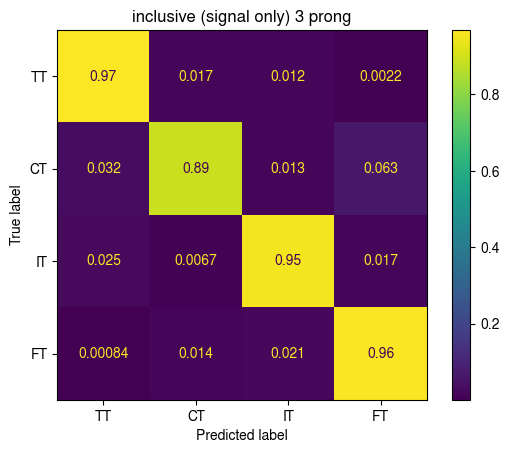

In [37]:
confusion_matrix = metrics.confusion_matrix(valid_truth3, f3, normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['TT', 'CT', 'IT', 'FT'])

cm_display.plot()
plt.title('inclusive (signal only) 3 prong')
plt.show()

In [38]:
sig_mask_1.shape

(3000000,)

In [39]:
one_prong_jet_mask = [np.sum(track_true_labels == 1) == 1  for track_true_labels in track_truth]

In [40]:
np.sum(l == True for l in one_prong_jet_mask)

/tmp/ipykernel_108685/3261831915.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(l == True for l in one_prong_jet_mask)


2069771

In [41]:
one_prong_jet_mask = np.array(one_prong_jet_mask)

In [42]:
filtered_1_prongs = filtered_tau[one_prong_jet_mask & sig_mask_1]

In [43]:
track_scores1 = [filtered_1_prongs[:,:,0], filtered_1_prongs[:,:,1], filtered_1_prongs[:,:,2], filtered_1_prongs[:,:,3]]
track_valid1 = filtered_1_prongs[:,:,4]
track_truth1 = filtered_1_prongs[:,:,5]

In [44]:
track_valid1 = np.where(track_valid1 == 1, True, False)

In [45]:
valid_truth1 = track_truth1[track_valid1]
valid_truth1[valid_truth1 == 6] = 0
valid_truth1[valid_truth1 == 5] = 0
valid_truth1[valid_truth1 == 4] = 0
valid_truth1.shape

(24340231,)

In [46]:
rnn_scores1 = np.stack([track_scores1[0], track_scores1[1], track_scores1[2], track_scores1[3]], axis=-1)


In [47]:
f1 = np.argmax(rnn_scores1[track_valid1], axis = -1)

In [48]:
f1 = relabel(f1)

In [49]:
valid_truth1 = relabel(valid_truth1)

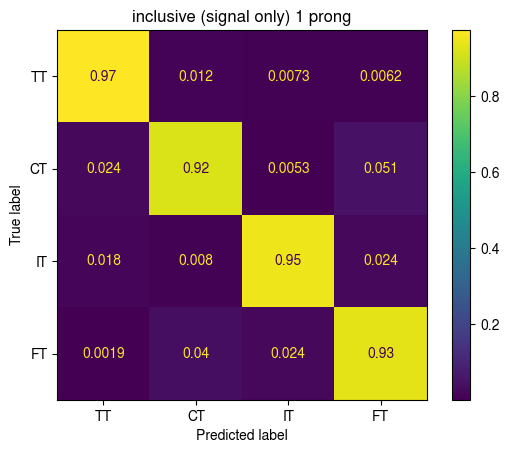

In [50]:
confusion_matrix = metrics.confusion_matrix(valid_truth1, f1, normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['TT', 'CT', 'IT', 'FT'])

cm_display.plot()
plt.title('inclusive (signal only) 1 prong')
plt.show()